# The Rumos Bank Marketing Campaign


The marketing team wants to launch a new campaign aimed at convincing customers to open term deposits.

Until now, the strategy was to call as many people as possible indiscriminately and try to sell them the product. However, this approach not only consumes more resources because it requires having several people call all the customers, but it is also inconvenient for some customers who do not like to be disturbed with such calls. Upon review, it was concluded that:

For each customer identified as a good candidate and targeted by the campaign but does not adhere to the term deposit, the bank incurs a cost of 500 euros.
For each customer identified as a bad candidate and thus not targeted by the campaign but who actually was a good candidate and would have adhered, the bank incurs a cost of 2000 euros.

Based on this information, we will create a model that selects the best candidates to target for the campaign, in order to reduce costs.


**Dataset features details:**

    1 - age
    2 - job : type of job
    3 - marital : marital status
    4 - education
    5 - default: has credit in default?
    6 - housing: has housing loan?
    7 - loan: has personal loan?
    8 - pdays: number of days that passed by after the client was last contacted from a previous campaign
    9 - previous: number of contacts performed before this campaign and for this client
    10 - poutcome: outcome of the previous marketing campaign
    11 - emp.var.rate: employment variation rate - quarterly indicator
    12 - cons.price.idx: consumer price index - monthly indicator
    13 - cons.conf.idx: consumer confidence index - monthly indicator
    14 - euribor3m: euribor 3 month rate - daily indicator
    15 - nr.employed: number of employees - quarterly indicator

**Output:**
    
    y: has the client subscribed a term deposit?
    
   

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

seed = 42

In [286]:
df = pd.read_csv('bank_marketing_campaign.csv', low_memory=False)

### Exploratory Data Analysis

Let's start by defining the confusion matrix:

    True Positive (TP): Correctly identified as a good candidate.
    True Negative (TN): Correctly identified as a bad candidate.
    False Positive (FP): Incorrectly identified as a good candidate (cost: 500 euros).
    False Negative (FN): Incorrectly identified as a bad candidate (cost: 2000 euros).

In [287]:
df.head()

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [288]:
df.shape

(41188, 16)

The dataset contains 41,188 clients and 15 features. It represents a supervised classification problem. The target variable, "y," with values "yes" and "no", indicates the binary classification nature of the task.

In [289]:
df.y.value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [290]:
df.y.value_counts(normalize = True)*100

y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

We have an imbalanced class distribution of the target variable: 36,548 clients (88%) have not subscribed to a term deposit, while only 4,640 clients (11.2%) have subscribed.

### Correlation Analysis

Let's first split the analysis into numerical and categorical features:

In [291]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [292]:
df.dtypes.value_counts()

object     8
float64    5
int64      3
Name: count, dtype: int64

In [293]:
df.head(2)

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [294]:
#Start by mapping values 0 and 1 to target feature 'yes' and 'no':

#Convert the values to lowercase to ensure consistency.
df['y'] = df['y'].str.strip().str.lower()

# Map the values to 1 and 0
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.head(3)

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [295]:
numerical_df = df.select_dtypes(include = ['number']).copy()
numerical_df.head(2)

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [296]:
categorical_df = df.select_dtypes(include = ['object']).copy()
categorical_df["y"] = df["y"]
categorical_df

,job,marital,education,default,housing,loan,poutcome,y
0,housemaid,married,basic.4y,no,no,no,nonexistent,0
1,services,married,high.school,unknown,no,no,nonexistent,0
2,services,married,high.school,no,yes,no,nonexistent,0
3,admin.,married,basic.6y,no,no,no,nonexistent,0
4,services,married,high.school,no,no,yes,nonexistent,0
...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,nonexistent,1
41184,blue-collar,married,professional.course,no,no,no,nonexistent,0
41185,retired,married,university.degree,no,yes,no,nonexistent,0
41186,technician,married,professional.course,no,no,no,nonexistent,1


**Numeric features correlation:**

In [297]:
corr_pearson = numerical_df.corr(method = 'pearson')
corr_pearson

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
pdays,-0.034369,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,0.030399,-0.324914,0.230181,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


In [298]:
corr_pearson["y"].sort_values(ascending = False)

y                 1.000000
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y, dtype: float64

With p-value to see if the correlation is statistically significant (p-value must be < 0.05):

In [299]:
X = numerical_df.drop(columns=['y'])  
y = numerical_df['y']

In [300]:
import scipy
import numpy as np

print("col                    corr  pval")
for col in numerical_df.columns:
    corr = np.nan
    pval = np.nan
    if numerical_df[col].nunique() > 1:  # Check if column has more than one unique value (adjusting the code due to null values in total_rec_late_fee)
        corr, pval = scipy.stats.pearsonr(numerical_df[col], y)

    print(f"{col: <20}  {corr: >5.2f}  {pval:4.2f}")

col                    corr  pval
age                    0.03  0.00
pdays                 -0.32  0.00
previous               0.23  0.00
emp.var.rate          -0.30  0.00
cons.price.idx        -0.14  0.00
cons.conf.idx          0.05  0.00
euribor3m             -0.31  0.00
nr.employed           -0.35  0.00
y                      1.00  0.00


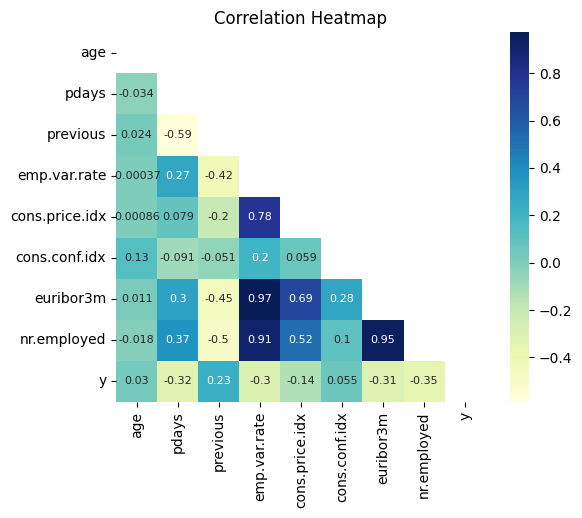

In [301]:
# Heatmap for better visualization
import seaborn as sns


sns.heatmap(
    corr_pearson,
    annot=True,
    cmap = 'YlGnBu',
    square = True,
    mask = np.triu(corr_pearson.notnull()),
    annot_kws={"fontsize": 8}
);

plt.title('Correlation Heatmap')
plt.show()

Based on the Pearson's correlation matrix and heatmap, the following features exhibit the highest correlation with the target variable, which indicates whether a customer subscribed to a term deposit:

*   **"nr.employed"**: This feature, which represents the number of employees (a
quarterly indicator), has a correlation of -0.35 with the target variable. This negative correlation suggests that as the number of employed individuals increases, the likelihood of a customer subscribing to a term deposit decreases.
*   **"pdays"**: This feature, which denotes the number of days that have passed since the client was last contacted in a previous campaign, has a correlation of -0.32 with the target variable. A negative correlation indicates that the longer the time since the last contact, the less likely the client is to subscribe to a term deposit.
*   **"euribor3m"**: This feature, which represents the Euribor 3-month rate (a daily indicator), has a correlation of -0.31 with the target variable. This negative correlation implies that higher Euribor rates are associated with a decreased likelihood of customers subscribing to a term deposit.



**Categorical features correlation:**

I will use Chi-Square test to examine the independence of the categorical variables with target feature. Although it doesn't provide a correlation coefficient, it gives a p-value indicating whether the variables are related.

In [302]:
categorical_df.head(2)

,job,marital,education,default,housing,loan,poutcome,y
0,housemaid,married,basic.4y,no,no,no,nonexistent,0
1,services,married,high.school,unknown,no,no,nonexistent,0


In [303]:
X_cat = categorical_df.drop(columns = ["y"])
y_cat = categorical_df["y"]

In [304]:
import pandas as pd
from scipy.stats import chi2_contingency

for col in X_cat.columns:
    table = pd.crosstab(X_cat[col], y_cat)
    print ('\n', table)
    _, pval, _, expected_table = chi2_contingency(table)
    print('Feature:', col, '| p-value:', pval)




 y                 0     1
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37
Feature: job | p-value: 4.189763287563623e-199

 y             0     1
marital              
divorced   4136   476
married   22396  2532
single     9948  1620
unknown      68    12
Feature: marital | p-value: 2.068014648442211e-26

 y                        0     1
education                       
basic.4y              3748   428
basic.6y              2104   188
basic.9y              5572   473
high.school           8484  1031
illiterate              14     4
professional.course   4648   595
university.degree    10498  1670
unknown               1480   251
Feature: education | p-value: 3.3051890144025054e-38

 y            0  

In [305]:
chi2_contingency(pd.crosstab(X_cat["job"], y_cat))

Chi2ContingencyResult(statistic=961.2424403289555, pvalue=4.189763287563623e-199, dof=11, expected_freq=array([[9247.91822861, 1174.08177139],
       [8211.49830048, 1042.50169952],
       [1291.97552685,  164.02447315],
       [ 940.58657862,  119.41342138],
       [2594.59920365,  329.40079635],
       [1526.23482568,  193.76517432],
       [1260.91842284,  160.08157716],
       [3521.87559483,  447.12440517],
       [ 776.42760027,   98.57239973],
       [5983.37292415,  759.62707585],
       [ 899.76867049,  114.23132951],
       [ 292.82412353,   37.17587647]]))

Based on the results, we can see that the feature **"job"** shows the lowest p-value among all features analyzed using the chi-square test of independence. This low p-value indicates the highest level of statistical significance for the "job" feature and provides sufficient evidence to reject the null hypothesis that the features are independent.

Furthermore, the observed counts for the "job" feature deviate significantly from the expected counts generated by the chi-square test. This deviation suggests that there is a dependency between the "job" feature and the target variable.

In summary, the low p-value and substantial deviation of observed counts from expected counts indicate that the "job" feature is likely to be a strong predictor of the target variable, showing a meaningful relationship or dependency between the two variables.

### Data Cleaning and Preprocessing

Before I proceed with the modelling, let's see if there are any missing values, encode the categorical features and scale the numerical ones:

**Missing values:**

In [306]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values in the dataset. 


**Let's split the dataset into test and train:**

In [307]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['y'], axis = 'columns')
y_train = train_set['y']

X_test = test_set.drop(['y'], axis = 1)
y_test = test_set['y']

**Numerical features scaling:**

In [308]:
numerical_df.head(2)

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [309]:
numerical_features = ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale numerical features in the training dataset (X_train)
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

X_train = pd.DataFrame(X_train, columns=X_train.columns)

X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Convert X_test back to a DataFrame
X_test = pd.DataFrame(X_test, columns=X_test.columns)

X_train.head(3)

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
12556,0.283951,blue-collar,married,basic.9y,unknown,yes,no,1.0,0.000000,nonexistent,1.000000,0.669135,0.338912,0.980730,1.000000
35451,0.172840,admin.,married,university.degree,no,no,no,1.0,0.000000,nonexistent,0.333333,0.269680,0.192469,0.138291,0.512287
30592,0.518519,retired,married,basic.4y,no,no,no,1.0,0.142857,failure,0.333333,0.269680,0.192469,0.163228,0.512287


**Categorical features encoding:**

In [310]:
categorical_df.head(5)

,job,marital,education,default,housing,loan,poutcome,y
0,housemaid,married,basic.4y,no,no,no,nonexistent,0
1,services,married,high.school,unknown,no,no,nonexistent,0
2,services,married,high.school,no,yes,no,nonexistent,0
3,admin.,married,basic.6y,no,no,no,nonexistent,0
4,services,married,high.school,no,no,yes,nonexistent,0


The feature "education" has an ordinal relation, so we'll apply the Ordinal Encoding:

In [311]:
df.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [312]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc_education = OrdinalEncoder(categories=[["unknown", "illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"]])

X_train["education"] = ord_enc_education.fit_transform(X_train[["education"]])
X_test["education"] = ord_enc_education.transform(X_test[["education"]])

X_train.education.head(4)

12556    4.0
35451    7.0
30592    2.0
17914    4.0
Name: education, dtype: float64

The remaining categorical features have no ordinal relationship or binary nature (the ones that appear to have, also have a category "unknown" which we will take into consideration as well). Based on that, I will apply OHE One Hot Encoding to the remaining features:

In [313]:
pip install category_encoders


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [314]:
from category_encoders import OneHotEncoder as OHE

categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']

ohe_enc = OHE(cols=categorical_features, use_cat_names=True)

X_train_encoded = ohe_enc.fit_transform(X_train)
X_test_encoded = ohe_enc.transform(X_test)

In [315]:
X_train_encoded.head(2)

,age,job_blue-collar,job_admin.,job_retired,job_housemaid,job_management,job_technician,job_entrepreneur,job_services,job_student,...,pdays,previous,poutcome_nonexistent,poutcome_failure,poutcome_success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
12556,0.283951,1,0,0,0,0,0,0,0,0,...,1.0,0.0,1,0,0,1.000000,0.669135,0.338912,0.980730,1.000000
35451,0.172840,0,1,0,0,0,0,0,0,0,...,1.0,0.0,1,0,0,0.333333,0.269680,0.192469,0.138291,0.512287


In [316]:
X_train_encoded.shape

(32950, 37)

I've encoded categorical features, resulting in a total of 37 features. However, dealing with such a high-dimensional feature space can lead to overfitting and slow training times. To address this, we’ll employ PCA (Principal Component Analysis) as a dimensionality reduction technique.

PCA aims to transform the original data into a set of principal components that capture the maximum variance. By doing so, we retain most of the information while reducing the number of features. Its primary goal is to minimize projection error while maximizing information preservation.

I will allow PCA to determine the optimal number of components (denoted as (d)) such that the cumulative sum of variance exceeds 0.95, indicating that it captures at least 95% of the data variation:

In [317]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_encoded)

cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components = d)

X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

X_train = pd.DataFrame(X_train_pca, columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14'])
X_test = pd.DataFrame(X_test_pca, columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14'])



In [318]:
d

14

In [319]:
X_train.head(2)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14
0,1.144517,-0.296737,-1.227933,0.090027,0.740837,-0.246688,-0.058060,-0.513828,0.197074,0.091180,-0.097327,-0.049794,0.093143,-0.017815
1,-2.097457,-0.321707,0.698684,0.799461,-0.083068,-0.132921,0.673429,-0.179893,-0.138127,-0.457896,-0.224950,-0.247414,-0.071425,-0.012153


We have obtained a total of 14 features, which are the result of merging the principal components.

### Baseline Cost

**Baseline (cost without any model involved):**

$$totalCost = 500∗FP+2000∗FN$$

*For Class 1: Client has subscribed to term deposit (Only Positives):*

In [321]:
y_preds_all_bad = np.ones(y_test.shape)
#creates creates an array of ones with the same shape as y_test

accuracy = accuracy_score(y_test, y_preds_all_bad)
accuracy

0.11349842194707453

In [322]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 935
Number of False Negatives: 0
Number of False Positives: 7303


In [323]:
print('Total Cost:', fp*500)
# 500 because that's the cost of False Positives

Total Cost: 3651500


If all the clients were considered as **good candidates** for term deposit, that would cost **3,651,500€** to the bank.

*For Class 0: Client has not subscribed to term deposit (Only Negatives):*

In [324]:
y_preds_all_good = np.zeros(y_test.shape)

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 7303
Number of True Positives: 0
Number of False Negatives: 935
Number of False Positives: 0


In [325]:
print('Total Cost:', fn*2000)

Total Cost: 1870000


If all the clients were considered as **bad candidates** for term deposit, that would cost **1,870,000€** to the bank.

In this scenario, where the total baseline cost of false positives (€3.65MM) outweighs that of false negatives (€1.87MM), prioritizing the reduction of false positives becomes imperative for minimizing the overall financial burden on the business. While the individual cost per false negative (2000€) may be higher than that of false positives (500€), the cumulative impact of false positives on the total cost is more significant.

Therefore, selecting a threshold of 0.5, which is commonly used as the default threshold in binary classification, aligns well with the objective of mitigating the financial effects of false positives. By adopting a threshold of 0.5, the model tends to be on the side of caution, leading to more conservative predictions and a higher likelihood of correctly classifying negative instances, thus reducing the incidence of false positives. Consequently, while some false negatives may occur due to the conservative nature of the threshold, the overall financial savings achieved by minimizing false positives outweighs the cost of missed positive instances.

In [326]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the total cost function
def total_cost(y_test, y_preds, threshold=0.5):
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    cost_fn = fn * 2000  # Cost for False Negatives
    cost_fp = fp * 500   # Cost for False Positives
    return cost_fn + cost_fp

# Define the function to find the threshold with minimum cost
def min_cost_threshold(y_test, y_preds):
    costs = {}

    # Calculate costs for each threshold
    for threshold in np.arange(0, 1.1, 0.1):
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold=threshold)

    # Plot the costs
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.title('Cost vs Threshold')
    plt.show()

    # Find the threshold with the minimum cost
    min_threshold = min(costs, key=costs.get)
    min_cost = costs[min_threshold]

    print(f"Minimum cost: {min_cost} at threshold: {min_threshold}")
    return min_threshold, min_cost
# min_threshold, min_cost = min_cost_threshold(y_test, y_preds)

For each algorithm, the evaluation will focus on three main criteria:

*Minimum Cost vs. Threshold:* This criterion is the most crucial as it directly relates to the financial impact of the model's predictions. We will determine the threshold that minimizes the total cost, considering the costs associated with false positives and false negatives.

*Precision-Recall Curve (PRC):* PRC is a suitable metric for evaluating performance on imbalanced data, which is our case. This curve illustrates the trade-off between precision and recall, allowing us to assess the model's ability to correctly identify positive instances while minimizing false positives. Also, accuracy can be misleading on imbalanced datasets, where a classifier can achieve high accuracy by simply predicting the majority class most of the time, while ignoring the minority class. PRC, on the other hand, focuses on the performance of the classifier specifically on the positive class, making it more sensitive to imbalanced classes.

*F1 Score:* The F1 score provides a balanced measure of the model's precision and recall. It is particularly useful for evaluating classifiers on imbalanced datasets as it considers both false positives and false negatives.

By examining these criteria, we aim to gain a better understanding of each algorithm's performance, considering both the financial implications and the ability to effectively handle the imbalanced nature of the dataset.

### Machine Learning

**Logistic Regression**

In [327]:
%%time
# Define Logistic Regression classifier;  class_weight parameter to handle class imbalance and 'lbfgs' solver for multi-class classification problem
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )

# Define hyperparameter grid for C (overfit regularization)
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}

#Search for best hyperparamether of C, with cross-validation of 5:
clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 636 ms


In [328]:
clf_lr.score(X_test, y_test)

0.7416848749696529

In [329]:
y_preds = clf_lr.predict_proba(X_test)[:,1]
total_cost(y_test, y_preds, threshold = 0.5)

1499000

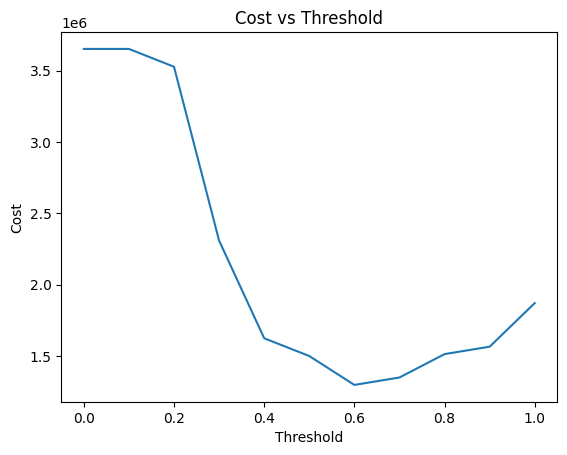

Minimum cost: 1296500 at threshold: 0.6


(0.6, 1296500)

In [330]:
min_cost_threshold(y_test, y_preds)


The minimum cost of **1,296,500€** at threshold 0.6 means that this is the total cost incurred by the Logistic Regression model, considering both false positives and false negatives, and it's optimized based on the chosen threshold. This value is already better than the baseline costs!

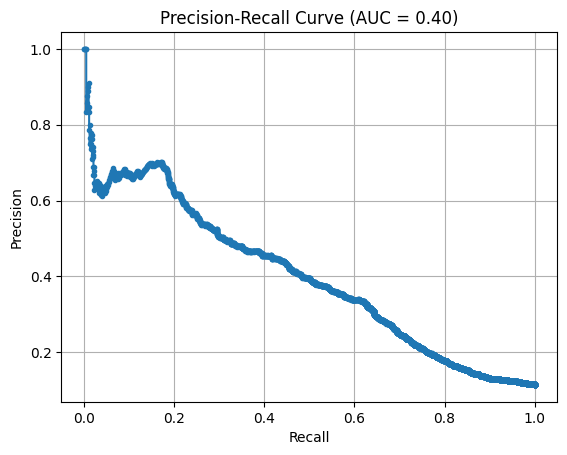

In [331]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    
    # Calculate area under the curve (AUC) for PRC
    prc_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()

plot_prc(y_test, y_preds)



In [332]:
from sklearn.metrics import f1_score

def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    y_preds = (y_preds >= threshold).astype(int)
    f1 = f1_score(y_test, y_preds)
    return f1

f1 = calculate_f1_with_threshold(y_test, y_preds)
print("F1-score:", f1)


F1-score: 0.3774136922176711



This model demonstrates improvements over the baseline performance, as indicated by the PRC Area Under the Curve (AUC) of 0.4 and an F1 score of 0.377. Additionally, achieving a minimum cost of €1.296 million suggests effective cost management compared to the baseline cost. The logistic regression model's choice of a threshold of 0.6, higher than the default 0.5, reflects its prioritization of minimizing false positives, aligning well with the higher total cost of false positives compared to false negatives. These results indicate promising advancements in both classification accuracy and cost optimization, showcasing the model's potential for practical application.

**KNN**

In [333]:
%%time
# Define K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()

# Define hyperparameter grid for n_neighbors
parameters = {'n_neighbors': range(1,40, 1)}

# Perform GridSearchCV with cross-validation of 5
clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 9.47 s
Wall time: 53.3 s


In [334]:
y_preds = clf_knn.predict_proba(X_test)[:,1]

clf_knn.score(X_test, y_test)

0.8958485069191552

In [335]:
total_cost(y_test, y_preds, threshold = 0.5)

1578000

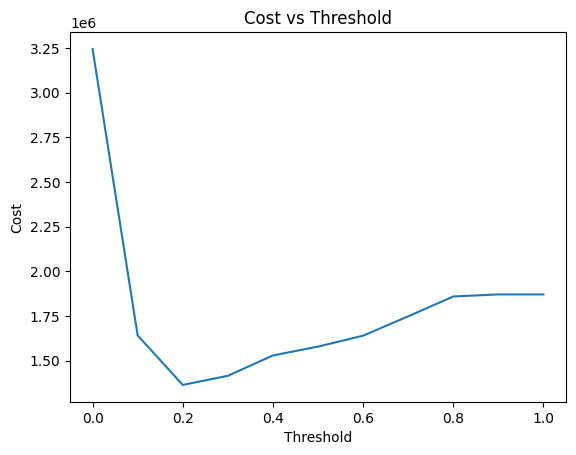

Minimum cost: 1363500 at threshold: 0.2


(0.2, 1363500)

In [336]:
min_cost_threshold(y_test, y_preds)

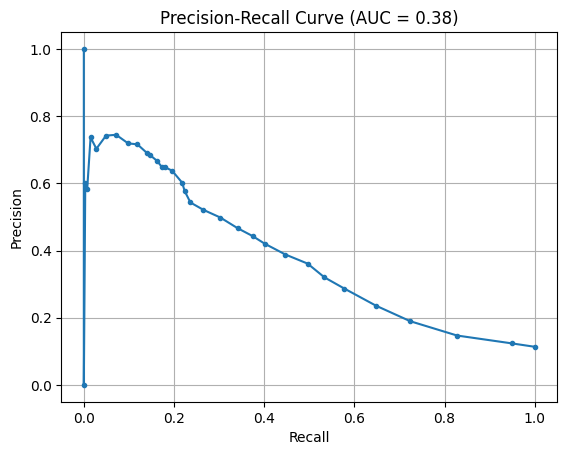

In [337]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    
    # Calculate area under the curve (AUC) for PRC
    prc_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()

plot_prc(y_test, y_preds)



In [338]:
from sklearn.metrics import f1_score

def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    y_preds = (y_preds >= threshold).astype(int)
    f1 = f1_score(y_test, y_preds)
    return f1


f1 = calculate_f1_with_threshold(y_test, y_preds)
print("F1-score:", f1)


F1-score: 0.2826086956521739


The K-Nearest Neighbors (KNN) model showcases improvements over the baseline performance, achieving a minimum cost of 1.36 million euros at a threshold of 0.2 (minimizing the False Negatives). However, when compared to the logistic regression model, the KNN model exhibits inferior performance, as reflected by the lower minimum cost, PRC Area Under the Curve (AUC) of 0.38 and a lower F1 score of 0.282. This suggests that the KNN model may struggle to strike the desired balance between precision and recall, leading to suboptimal classification accuracy and cost optimization.

**Decision Trees**

In [339]:
%%time

# Define Decision Tree classifier
trees = tree.DecisionTreeClassifier(random_state = seed)


# Define hyperparameter grid for max_depth and min_samples_split
parameters = {'max_depth':[3, 6], 'min_samples_split': [2, 4, 10]}

# Perform GridSearchCV with cross-validation of 5
clf_tree = GridSearchCV(trees, parameters, cv = 5).fit(X_train, y_train)

CPU times: total: 750 ms
Wall time: 4.94 s


In [340]:
y_preds = clf_tree.predict_proba(X_test)[:,1]

clf_tree.score(X_test, y_test)

0.8953629521728574

In [341]:
total_cost(y_test, y_preds, threshold = 0.5)

1560500

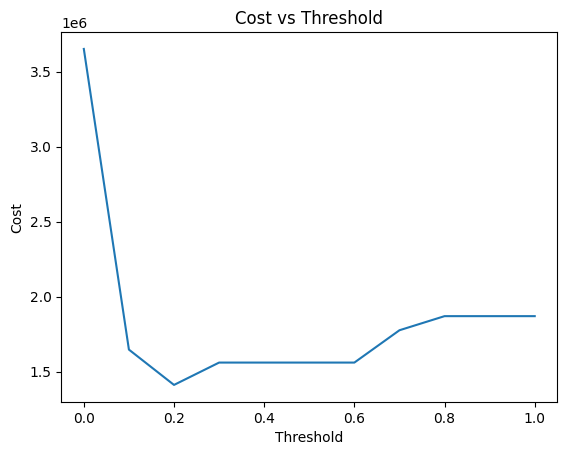

Minimum cost: 1411500 at threshold: 0.2


(0.2, 1411500)

In [342]:
min_cost_threshold(y_test, y_preds)

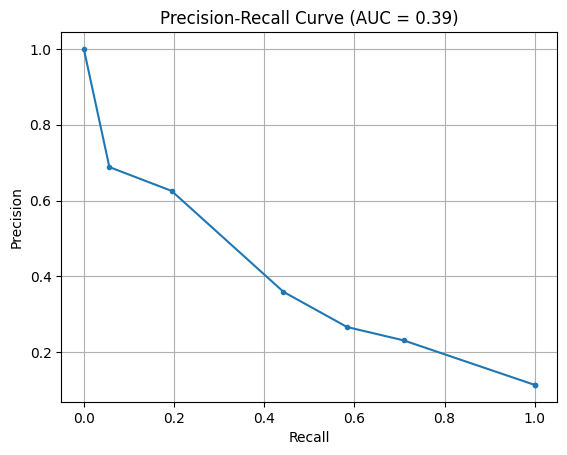

In [343]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()


plot_prc(y_test, y_preds)


In [344]:
from sklearn.metrics import f1_score

def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    y_preds = (y_preds >= threshold).astype(int)
    f1 = f1_score(y_test, y_preds)
    return f1


f1 = calculate_f1_with_threshold(y_test, y_preds)
print("F1-score:", f1)


F1-score: 0.2969004893964111


Similar to the K-Nearest Neighbors (KNN) model, the Decision Tree classifier demonstrates inferior performance compared to the logistic regression model. Despite its effectiveness in cost management, the Decision Tree model's lower PRC AUC and F1 score suggest limitations in achieving a balance between precision and recall.

**Random Forests**

In [345]:
%%time
# Define Random Forest classifier
rf = RandomForestClassifier(random_state = seed,  class_weight = 'balanced')

# Define hyperparameter grid for n_estimators
parameters = {'n_estimators':[10, 100, 300, 1000]}

# Perform GridSearchCV with cross-validation of 5
clf_rf = GridSearchCV(rf, parameters, cv = 5, n_jobs=-1).fit(X_train, y_train)

#The n_jobs specifies the number of parallel jobs to run during cross-validation. When set to -1, it means that the computation will utilize all available CPU cores, effectively parallelizing the job across multiple cores for faster execution.

CPU times: total: 281 ms
Wall time: 1min 44s


In [346]:
y_preds = clf_rf.predict_proba(X_test)[:,1]

clf_rf.score(X_test, y_test)

0.8678077203204662

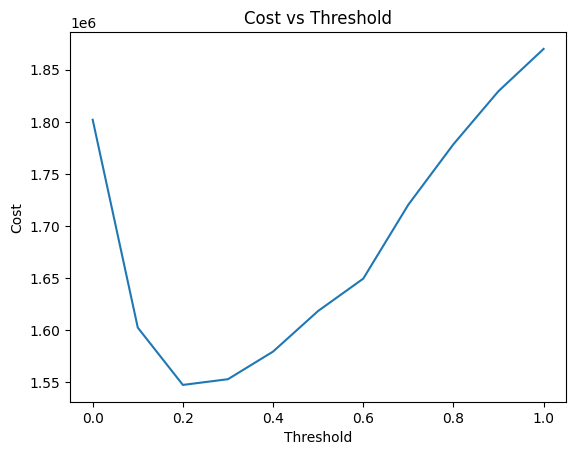

Minimum cost: 1547500 at threshold: 0.2


(0.2, 1547500)

In [347]:
min_cost_threshold(y_test, y_preds)

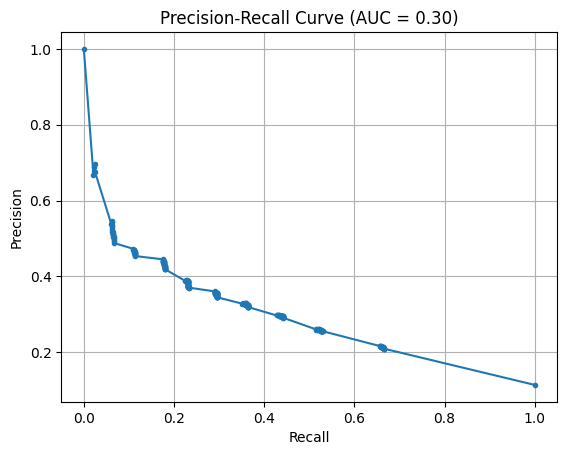

In [348]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()



plot_prc(y_test, y_preds)


In [349]:
from sklearn.metrics import f1_score

def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    y_preds = (y_preds >= threshold).astype(int)
    f1 = f1_score(y_test, y_preds)
    return f1


f1 = calculate_f1_with_threshold(y_test, y_preds)
print("F1-score:", f1)


F1-score: 0.3212803793716657


In comparison to logistic regression, KNN, and Decision Tree models, the Random Forest model demonstrates weaker performance in both cost optimization and classification accuracy. The Random Forest's minimum cost of 1.54MM and lower PRC AUC suggest it struggles with precision and recall balance. This is unusual, as random forests typically outperform single decision trees due to their ensemble nature and to reduce the risk of overfitting from decision trees. Given this anomaly, we should be cautious when interpreting tree-based methods on this dataset.

**Neural Networks**

In [350]:
%%time

# Define MLPClassifier with specified parameters
mlp = MLPClassifier(solver = 'lbfgs',  random_state = seed, max_iter = 1000 )

# Define hyperparameters grid for GridSearchCV
parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

# Perform GridSearchCV with cross-validation of 5 and utilize parallel processing
clf_mlp = GridSearchCV(mlp, parameters, cv = 5, n_jobs=-1).fit(X_train, y_train)




CPU times: total: 5.2 s
Wall time: 4min 5s


C:\Users\polin\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [351]:
y_preds = clf_mlp.predict_proba(X_test)[:,1]

clf_mlp.score(X_test, y_test)


0.8951201747997086

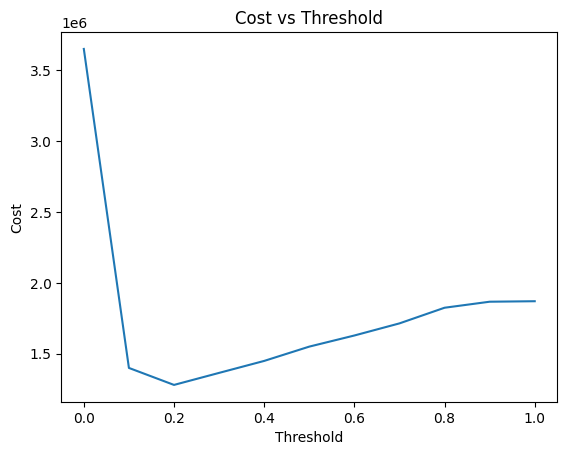

Minimum cost: 1279000 at threshold: 0.2


(0.2, 1279000)

In [352]:
min_cost_threshold(y_test, y_preds)

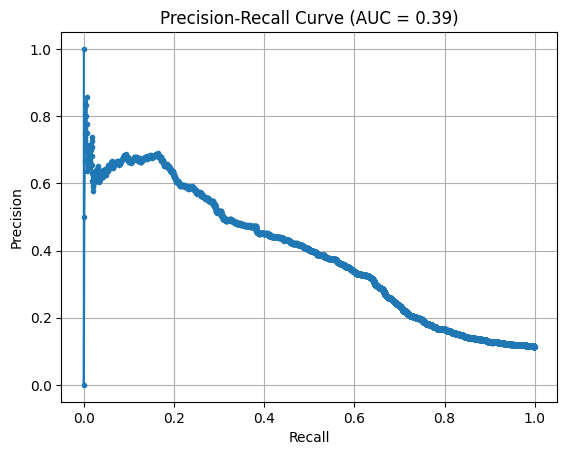

In [353]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()


plot_prc(y_test, y_preds)


In [354]:
from sklearn.metrics import f1_score

def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    y_preds = (y_preds >= threshold).astype(int)
    f1 = f1_score(y_test, y_preds)
    return f1


f1 = calculate_f1_with_threshold(y_test, y_preds)
print("F1-score:", f1)


F1-score: 0.3054662379421222


The neural network model demonstrates promising performance with a minimum cost of 1.279 million euros, slightly surpassing logistic regression's optimization (1.296 million euros) with a marginal difference. Operating at a threshold of 0.2, the focus was on minimizing False Negatives. 
While the PRC AUC and F1 values slightly lag behind logistic regression, the neural network's runtime was notably longer. 

Considering logistic regression's quicker runtime, emphasis on minimizing false positives (which may align with specific business needs), marginally superior performance in PRC AUC and F1 score, and capability to rank coefficients, it emerges as the more pragmatic choice. The slight discrepancy in cost (17k) may not outweigh logistic regression's advantages in speed and performance metrics. Hence, logistic regression remains the recommended option.

**SVM**

**NOTE**: Commenting out this algorithm because it took approximately 3 hours to run. The results are shown below, so there's no need to run this code again.

In [356]:
#%%time

#svc = SVC(random_state = seed, class_weight = 'balanced', gamma = 'scale', probability = True, verbose = True)

#I wanted to search for the ideal value of gamma using GridSearchCV to optimize the hyperparameter. However, the code was taking too long to run, so I had to set it to 'scale' to minimize the runtime.

#parameters = {'C':[0.1, 1, 10], 'kernel': ('rbf', 'linear') }


#clf_svc = GridSearchCV(svc, parameters, cv = 5, n_jobs=-1).fit(X_train, y_train)

In [ ]:
#y_preds = clf_svc.predict_proba(X_test)[:,1]
#clf_rf.score(X_test, y_test)

0.8693857732459335

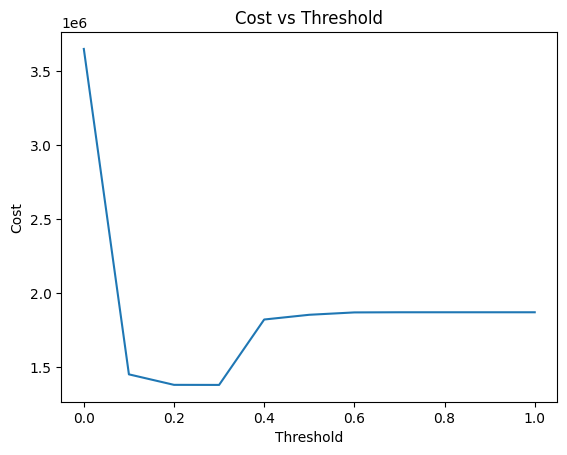

Minimum cost: 1378500 at threshold: 0.3


(0.3, 1378500)

In [ ]:
#min_cost_threshold(y_test, y_preds)

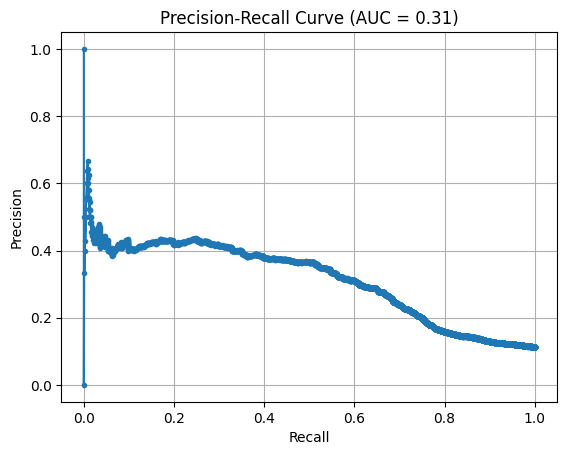

In [ ]:
#from sklearn.metrics import precision_recall_curve, auc
#import matplotlib.pyplot as plt

#def plot_prc(y_test, y_preds):
    #precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    #prc_auc = auc(recall, precision)
    #plt.plot(recall, precision, marker='.')
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    #plt.grid(True)
    #plt.show()


#plot_prc(y_test, y_preds)


In [ ]:
#from sklearn.metrics import f1_score

#def calculate_f1_with_threshold(y_test, y_preds, threshold=0.5):
    # Convert probabilities to binary labels based on the threshold
    #y_preds = (y_preds >= threshold).astype(int)
    #f1 = f1_score(y_test, y_preds)
    #return f1


#f1 = calculate_f1_with_threshold(y_test, y_preds)
#print("F1-score:", f1)


F1-score: 0.02098635886673662


The SVM model achieved a minimum cost of 1.378 million euros at a threshold of 0.3, with a PRC AUC of 0.31 and an F1 score of 0.02. These results indicate that the SVM model is less effective in cost optimization and performance metrics compared to other algorithms tested. Additionally, the SVM model took significantly longer to run, approximately 3 hours, making it impractical for use in this context.

### Conclusion

**Models training summary:**

After evaluating all relevant algorithms, here's a summary of our findings:

    Logistic Regression: 1,296,500€; PRC AUC: 0.40; F1: 0.377
    KNN:                 1,363,500€; PRC AUC: 0.38; F1: 0.283
    Decision Trees:      1,411,500€; PRC AUC: 0.39; F1: 0.296
    Random Forest:       1,547,000€; PRC AUC: 0.30; F1: 0.321
    Neural Network:      1,279,000€; PRC AUC: 0.39; F1: 0.305
    SVM:                 1,378,500€; PRC AUC: 0.31; F1: 0.02

Considering both the cost optimization and the business requirements, **Logistic Regression** emerges as the clear winner due to its lower cost and balanced performance across metrics.


If all the clients were considered as good candidates for term deposit, that would cost **3,651,500€** to the bank; and if all the clients were considered as bad candidates for term deposit, that would cost **1,870,000€** to the bank.

Using our model, the overall cost would be €1,296,500, resulting in a savings of more than half a million euros (€573,500) for the bank.

Additionally, thanks to the capability of Logistic Regression to rank coefficients, we can identify the importance of features and determine which ones contribute the most to the likelihood of a customer subscribing to a term deposit. Below, I used the pre-PCA dataset to extract the feature names corresponding to the coefficients:

In [357]:
%%time

# Define Logistic Regression classifier; class_weight parameter to handle class imbalance and 'lbfgs' solver for multi-class classification problem
lr = LogisticRegression(max_iter=500, solver='lbfgs', random_state=seed, class_weight='balanced')

# Define hyperparameter grid for C (overfit regularization)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Search for best hyperparameter of C, with cross-validation of 5:
clf_lr = GridSearchCV(lr, parameters, cv=5).fit(X_train_encoded, y_train)
score = clf_lr.score(X_test_encoded, y_test)
y_preds = clf_lr.predict_proba(X_test_encoded)[:, 1]

# Extract coefficients
coefs = pd.DataFrame(clf_lr.best_estimator_.coef_[0], index=X_train_encoded.columns, columns=['Coefficient'])

# Calculate the absolute values of coefficients
coefs['Abs_Coefficient'] = abs(coefs['Coefficient'])

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='Abs_Coefficient', ascending=False)


print("Model Coefficients (sorted by absolute value):")
print(coefs_sorted)

Model Coefficients (sorted by absolute value):
                      Coefficient  Abs_Coefficient
emp.var.rate            -2.225496         2.225496
pdays                   -1.366510         1.366510
nr.employed             -1.346814         1.346814
cons.price.idx           1.068405         1.068405
default_no               0.558215         0.558215
poutcome_success         0.505234         0.505234
job_retired              0.460483         0.460483
job_student              0.453085         0.453085
poutcome_nonexistent     0.446812         0.446812
previous                 0.438440         0.438440
cons.conf.idx            0.343187         0.343187
marital_unknown          0.325384         0.325384
euribor3m                0.316217         0.316217
default_unknown          0.285964         0.285964
loan_no                  0.276787         0.276787
housing_no               0.274589         0.274589
housing_yes              0.267936         0.267936
loan_yes                 0.265738  

From the sorted coefficients, we can conclude the following:

Features with the largest absolute coefficients have the most significant impact on predicting whether a client will subscribe to a term deposit.
In this model, the economic variables **emp.var.rate**, **pdays** and **nr.employed** are the strongest predictors. Specifically, a decrease in the employment variation rate (emp.var.rate), a decrease in the number of days since the client was last contacted (pdays), and decreases in the number of employees (nr.employed) are associated with a higher likelihood of subscription. These align with the correlation analysis we did before model training.

Categorical features such as default, poutcome, job, marital, and housing also play significant roles in predicting subscription.
For instance, having no credit default (default_no), a successful previous marketing campaign outcome (poutcome_success), being retired (job_retired), being a student (job_student), and having a previous nonexistent outcome (poutcome_nonexistent) are associated with a higher likelihood of subscription.

Last, features with smaller absolute coefficients, such as job_self-employed and job_entrepreneur, have less impact on the prediction compared to the stronger predictors mentioned above.


In summary, these coefficients provide insights into which features are most influential in determining whether a client will subscribe to a term deposit, guiding further analysis and decision-making in marketing strategies.

### EXTRA NOTE:

After analyzing the logistic regression coefficients using the pre-PCA dataset (which includes only encoded and scaled features), I observed a slight improvement in both the minimum cost and the Precision-Recall Curve (PRC) compared to the results obtained with PCA-transformed features: the minimum cost was €1.273 million (pre-PCA) versus €1.296 million (PCA), and the PRC AUC was 0.41 (pre-PCA) versus 0.40 (PCA). The difference in performance suggests the following considerations:

**Interpretability vs. Performance:**

*PCA-Transformed Features:*
While PCA captures essential variance, the resulting features may lack interpretability.
Logistic regression with these features might struggle to provide meaningful insights.

*Original Encoded Features:*
The original encoded features retain the raw information.
They may perform better if they contain crucial information for classification.


**Balancing Act:**

It’s essential to strike a balance between model interpretability and performance:

PCA: Simplicity, dimensionality reduction, but potentially less interpretable.

Encoded Features: More informative, but possibly more complex.





In conclusion, while PCA offers dimensionality reduction, leveraging the original encoded features can yield better performance and richer insights, striking an optimal balance between interpretability and model efficacy.

Also, despite trying other models for the pre-PCA dataset (KNN, Decision Trees, Random Forest), logistic regression consistently yielded the best results.

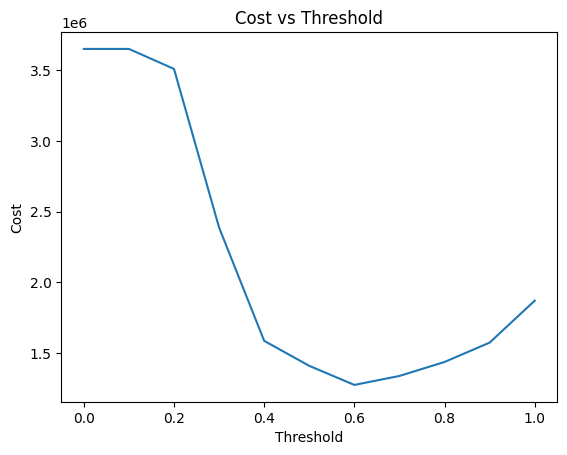

Minimum cost: 1273500 at threshold: 0.6


(0.6, 1273500)

In [ ]:
# Define Logistic Regression classifier; class_weight parameter to handle class imbalance and 'lbfgs' solver for multi-class classification problem
lr = LogisticRegression(max_iter=500, solver='lbfgs', random_state=seed, class_weight='balanced')

# Define hyperparameter grid for C (overfit regularization)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Search for best hyperparameter of C, with cross-validation of 5:
clf_lr = GridSearchCV(lr, parameters, cv=5).fit(X_train_encoded, y_train)
score = clf_lr.score(X_test_encoded, y_test)
y_preds = clf_lr.predict_proba(X_test_encoded)[:, 1]


min_cost_threshold(y_test, y_preds)




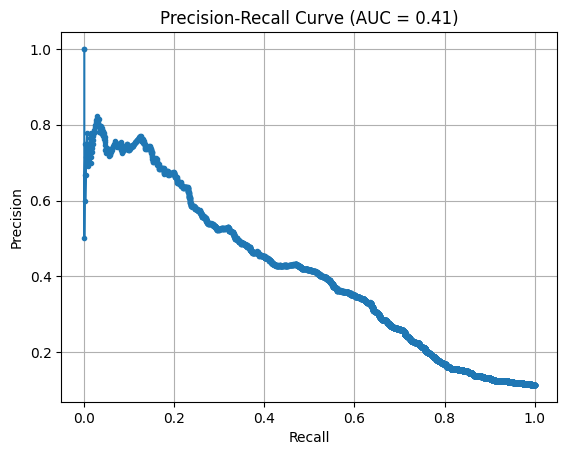

In [359]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_prc(y_test, y_preds):
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
    
    # Calculate area under the curve (AUC) for PRC
    prc_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(prc_auc))
    plt.grid(True)
    plt.show()

plot_prc(y_test, y_preds)